In [19]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [20]:
%matplotlib inline


In [21]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

#### Goal
- Mimic sudoku solver
- What do I need to do:
    - Extract word search grid
    - outline grid
    - extract numbers

#### Algoirthms and Why I need them
1. Gaussian Blur
    - Remove noise from image
    
2. Thresholding
    - Set thresholds to clearly differentiate image pixels:
    - Ex: all pixels > 125 become 255,  <= 125 become 0
    - Can't trust user camera, use adaptive threshold
    - Adaptive: Gaussian vs adaptive mean
    
3. Find contours
    - Choose largest rectangle using open cv contours
4. Find edge coordinates
    - Find vertex coordinates
5. Get perspective transform
    - Birds eye view
6. Resize Image?
7. Extract Grid


#### Sources
1. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
2. https://stackoverflow.com/questions/59182827/how-to-get-the-cells-of-a-sudoku-grid-with-opencv
3. Adaptive threshold function params: https://stackoverflow.com/questions/28763419/adaptive-threshold-parameters-confusion/28764902


In [105]:
import math

def resize(im):
    im = cv2.resize(im,(0,0),fx = 0.5, fy = 0.5)
    return im


def grayscale(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im
    
def gaussian_blur(im):
    im = cv2.GaussianBlur(im,(7,7),0)
    return im
    
def threshold(im):
    # threshold determined adaptively, max values rounded to 255
    im = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                       cv2.THRESH_BINARY_INV,15,2)
    return im

def canny(im):
    im = cv2.Canny(im,60,180)
    return im
def max_contour(im):
    im = np.uint8(im)
    cnts,_ = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    shapes = sorted(cnts,key = cv2.contourArea,reverse = True)
    #print(shapes[0].shape)
    max_cnt = shapes[0]
    return max_cnt


#source: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def vertex_coords(polygon):
    br_candidates = [coord[0][0]+coord[0][1] for coord in polygon]
    br = max(range(len(br_candidates)),key = br_candidates.__getitem__)
    
    bl_candidates = [coord[0][0]-coord[0][1] for coord in polygon]
    bl = min(range(len(bl_candidates)),key = bl_candidates.__getitem__)
    
    tr_candidates = [coord[0][0]-coord[0][1] for coord in polygon]
    tr = max(range(len(tr_candidates)),key = tr_candidates.__getitem__)
    
    tl_candidates = [coord[0][0]+coord[0][1] for coord in polygon]
    tl = min(range(len(tl_candidates)),key = tl_candidates.__getitem__)
    
    
    return (tl,tr,bl,br)


def dilation(im):
    kernel = np.ones((2,2),np.uint8)
    kernel2 = np.zeros((5,5),np.uint8)
    #im = gaussian_blur(im)
    #er = cv2.erode(im,kernel2,iterations = 1)
    #dil = cv2.dilate(er,kernel,iterations = 1)
    morp = cv2.morphologyEx(im,cv2.MORPH_OPEN,kernel)
    return morp

def euclidean_dist(pt1,pt2):
    dist_sq = (pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2
    dist = math.sqrt(dist_sq)
    return dist

def perspective_new_coords(vertices):
    tl,tr,bl,br = vertices
    width1 = euclidean_dist(tl,tr)
    width2 = euclidean_dist(bl,br)
    max_width = int(max(width1,width2))
    height1 = euclidean_dist(tl,bl)
    height2 = euclidean_dist(tr,br)
    max_height = int(max(height1,height2))
    new_coords = [[0,0],[max_width,0],
                  [0,max_height],[max_width,max_height]]
    return new_coords,max_width,max_height

# credit: https://stackoverflow.com/questions/59182827/how-to-get-the-cells-of-a-sudoku-grid-with-opencv
def remove_grid(im):
    # whiten out the grid
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
    detected_lines = cv2.morphologyEx(im, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
    detected_lines = cv2.morphologyEx(im, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
    cnts2 = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cnts2 = cnts2[0] if len(cnts) == 2 else cnts2[1]
    for c in cnts2:
        cv2.drawContours(im, [c], -1, (255,255,255), 3)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(im, [c], -1, (255,255,255), 3)
        
    return im
    
    
    
def perspective_shift(im,grid_contour):
    
    tl_idx,tr_idx,bl_idx,br_idx = vertex_coords(grid_contour)
    orig_coords = [grid_contour[tl_idx][0],grid_contour[tr_idx][0],
                   grid_contour[bl_idx][0],grid_contour[br_idx][0]]
    new_coords,nw,nh = perspective_new_coords(orig_coords)
    mat_trans = cv2.getPerspectiveTransform(np.float32(orig_coords),
                                            np.float32(new_coords))
    adjust_im = cv2.warpPerspective(im,mat_trans,(nw,nh))
    return adjust_im

def preprocess(im):
    resized_im = resize(im)
    gs_im = grayscale(resized_im)
    blurred = gaussian_blur(gs_im)
    thresh = threshold(blurred)
    grid_contour = max_contour(thresh)
    bird_eye_im = perspective_shift(thresh,grid_contour)
    dilated_im = dilation(bird_eye_im)
    invert_col = cv2.bitwise_not(dilated_im)
    remove_lines = remove_grid(invert_col)
    return remove_lines

def convex_hull_vis(im):
    resized_im = resize(im)
    gs = grayscale(resized_im)
    blurred = gaussian_blur(gs)
    thresh = threshold(blurred)
    grid_contour = max_contour(thresh)
    
    return (grid_contour,resized_im)
    


In [106]:
image = cv2.imread('crossword.jpg')
image2 = cv2.imread('crossword2.jpg')

(39, 1, 2)


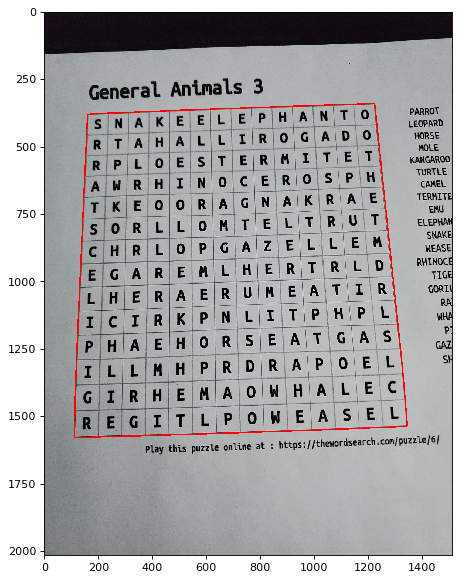

In [107]:
# we want to extract this
cont,im = convex_hull_vis(image)
hull = cv2.convexHull(cont)
print(hull.shape)
cv2.drawContours(im, [hull], 0, (255, 0, 0), 3)
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(im)

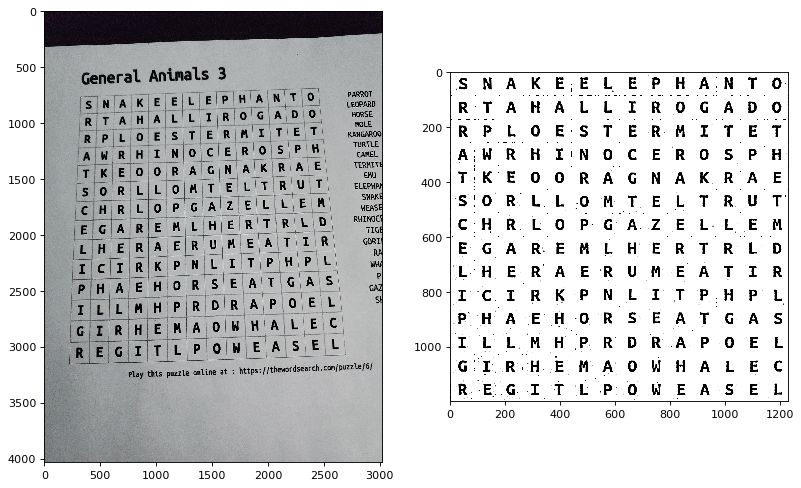

In [108]:
proc_img = preprocess(image)
f, ax = plt.subplots(1,2,figsize = (12,9),facecolor ='w',edgecolor = 'k',dpi = 80)
ax[0].imshow(image,cmap = 'gray')
ax[1].imshow(proc_img, cmap = 'gray')


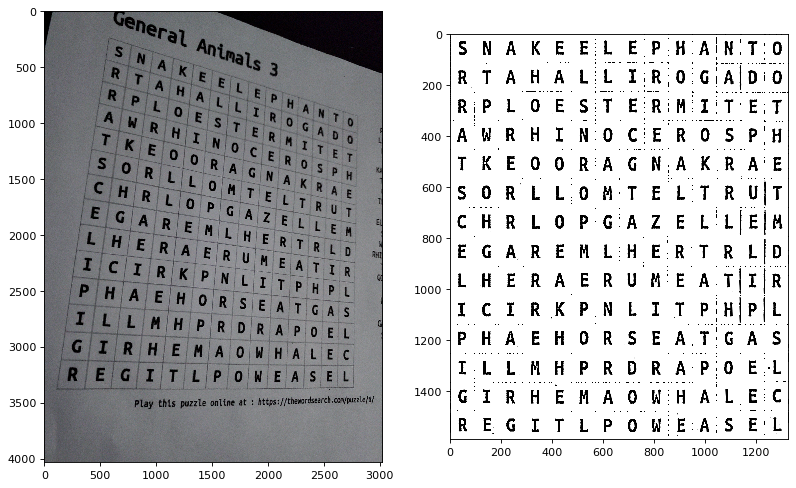

In [109]:
proc2 = preprocess(image2)
f, ax = plt.subplots(1,2,figsize = (12,9),facecolor ='w',edgecolor = 'k',dpi = 80)
ax[0].imshow(image2,cmap = 'gray')
ax[1].imshow(proc2,cmap = 'gray')

(1199, 1232)
85
[0, 86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118] [0, 88, 176, 264, 352, 440, 528, 616, 704, 792, 880, 968, 1056, 1144]



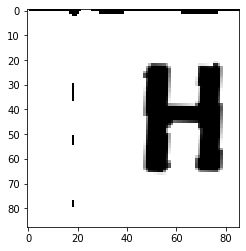

In [113]:
print(proc_img.shape)
m = 1199//14
print(m)
d = [i*86 for i in range(14)]
o = [i*88 for i in range(14)]
print(d,o)
y = pytesseract.image_to_string(proc_img[0:90,0:90])
print(y)
plt.imshow(proc_img[0:88,774:860],cmap="gray")

In [115]:
data = pytesseract.image_to_string(proc_img[85:170,88:176])
print(data)

(1199, 1232, 3)
[0, 88, 176, 264, 352, 440, 528, 616, 704, 792, 880, 968, 1056, 1144] [0, 86, 172, 258, 344, 430, 516, 602, 688, 774, 860, 946, 1032, 1118]


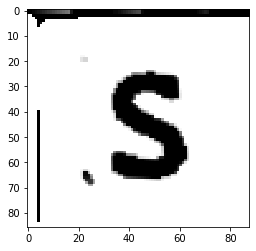

In [103]:
print(q.shape)
x_inds = [i*88 for i in range(14)]
y_inds = [i*86 for i in range(14)]
print(x_inds,y_inds)
plt.imshow(q[0:86,0:88])

In [100]:
data = pytesseract.image_to_string(q[0:86,0:88],config ="--psm 10")
print(data)

Ss



In [112]:
# ocr works incredible on normal words
words = cv2.imread('words.jpg')
data = pytesseract.image_to_string(words, lang='eng')
word_lst = data.split("\n")[:-1]
print(word_lst)

['PARROT', 'LEOPARD', 'HORSE', 'MOLE', 'KANGAROO', 'TURTLE', 'CAMEL', 'TERMITE', 'EMU', 'ELEPHANT', 'SNAKE', 'WEASEL', 'HINOCEROS', 'TIGER', 'GORILLA', 'RAT', 'WHALE', 'PIG', 'GAZELLE', 'SHARK']


#### Next steps
- Tesseract can't extract words form grid: alternative: manual grid size input on frontend, 2 file dropins
- Train mnist with alphabet for individual character detection
- Regex on list of words (ex related to spacing,linebreaks)